# Imports and constants


In [21]:
from typing import Any
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from transformers import (
    Mask2FormerImageProcessor,
    AutoImageProcessor,
    Mask2FormerForUniversalSegmentation,
)
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt
import albumentations as A
import evaluate
import gdown

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'wildscenes', 'tools'))
from utils2d import (
  METAINFO,
	cidx_2_class, 
	class_2_cidx, 
)

In [3]:
IGNORED_CLASSES = {0,1,12,13}
IMG_WIDTH = 2016
IMG_HEIGHT = 1512
BATCH_SIZE = 16

# CSV, dataset paths and file constants
Feel free to change the paths of the following accordingly 

In [4]:
TRAIN_CSV = "data/splits/opt2d/train.csv"
TEST_CSV = "data/splits/opt2d/test.csv"
VAL_CSV = "data/splits/opt2d/val.csv"

TRAIN_IMG_PATH = "data/processed/wildscenes_opt2d/train/image"
TRAIN_MASK_PATH = "data/processed/wildscenes_opt2d/train/indexLabel"
TEST_IMG_PATH = "data/processed/wildscenes_opt2d/test/image"
TEST_MASK_PATH = "data/processed/wildscenes_opt2d/test/indexLabel"
VAL_IMG_PATH = "data/processed/wildscenes_opt2d/val/image"
VAL_MASK_PATH = "data/processed/wildscenes_opt2d/val/indexLabel"

OUTPUT_DIR = os.getcwd()
TRAINED_DIR = os.getcwd()
CLASS_WEIGHTS = "class_weights.txt"
MODEL_NAME = "mask2former_v2"

# Dataset preprocessing and loading

**Description:**

- The `train_transforms` function is used to perform data augmentation on training images.

- The `test_val_transforms` function preprocesses images for testing and validation.

- The `collate_fn function` is utilized in PyTorch DataLoaders to aggregate individual data samples into batches.

- The `WildScenesDataset` class is a custom implementation of a PyTorch `Dataset` that is used to load and manage data for semantic segmentation tasks. It handles the loading of images and their corresponding labels from a dataset directory, applies necessary transformations, and provides an interface for indexing and accessing individual samples.

- The `get_dataset` function creates and returns instances of the `WildScenesDataset` class for training, validation, and testing datasets.

- The `get_dataloaders` function creates and returns PyTorch DataLoader instances for training, validation, and testing datasets


In [5]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)
df_val = pd.read_csv(VAL_CSV)

In [6]:
preprocessor = Mask2FormerImageProcessor(
    ignore_index=0,
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=True,
)

def train_transforms():
	return A.Compose([
			A.RandomCrop(width=224, height=224),
			A.VerticalFlip(p=0.5),

		])

def test_val_transforms():
	return A.Compose([
			A.Resize(width=224, height=224),

	])

@dataclass
class SegmentationDataInput:
    original_image: np.ndarray
    transformed_image: np.ndarray
    original_mask: np.ndarray
    transformed_mask: np.ndarray

class WildScenesDataset(Dataset):
		def __init__(self, df, img_dir, mask_dir, transform: Any = None):
				self.df = df
				self.img_dir = img_dir
				self.mask_dir = mask_dir
				self.transform = transform

		def __len__(self):
				return len(self.df)

		def __getitem__(self, idx):
				img_id = self.df.iloc[idx]['id']
				img_path = os.path.join(self.img_dir, img_id + '.png')
				mask_path = os.path.join(self.mask_dir, img_id + '.png')

				img = Image.open(img_path).convert("RGB")
				img = np.array(img).astype('uint8')

				mask = Image.open(mask_path).convert("L")
				mask = np.array(mask)

				augmented = self.transform(image=img, mask=mask)
				transformed_image = augmented['image']
				transformed_mask = augmented['mask']

				return SegmentationDataInput(
						original_image=img,
						transformed_image=transformed_image,
						original_mask=mask,
						transformed_mask=transformed_mask
				)

def collate_fn(batch: list) -> dict:
    original_images = [sample.original_image for sample in batch]
    transformed_images = [sample.transformed_image for sample in batch]
    original_masks = [sample.original_mask for sample in batch]
    transformed_masks = [sample.transformed_mask for sample in batch]

    preprocessed_batch = preprocessor(
        images=transformed_images,
        segmentation_maps=transformed_masks,
        return_tensors="pt"
    )

    preprocessed_batch["original_images"] = torch.stack([torch.tensor(img, dtype=torch.float32) for img in original_images])
    preprocessed_batch["original_masks"] = torch.stack([torch.tensor(mask, dtype=torch.long) for mask in original_masks])

    return preprocessed_batch

In [7]:
def get_dataset(
    df_train,
    train_img_path,
    train_mask_path,
    df_val,
    val_img_path,
    val_mask_path,
    df_test,
    test_img_path,
    test_mask_path
):
	train = WildScenesDataset(df_train,train_img_path,train_mask_path, transform=train_transforms())
	val = WildScenesDataset(df_val, val_img_path, val_mask_path, transform=test_val_transforms())
	test = WildScenesDataset(df_test, test_img_path, test_mask_path, transform=test_val_transforms())
	return train, val, test

def get_dataloaders(train, val, test, size):

	train_dataloader = DataLoader(
			train, batch_size=size, shuffle=True, collate_fn=collate_fn
	)
	val_dataloader = DataLoader(
			val, batch_size=size, shuffle=True, collate_fn=collate_fn
	)
	test_dataloader = DataLoader(
			test, batch_size=size, shuffle=False, collate_fn=collate_fn
	)
	return train_dataloader, val_dataloader, test_dataloader

# Loading weights and model

The `load_weights` function is used to load and process class weights from a file. It loads the weights from the given path, perform normalisation and scaling and set `weights = 0` for classes in `IGNORED_CLASSES`.

The `load_training_model` function sets up a Mask2Former model with a ConvNeXtV2 backbone and its associated preprocessor for training.


In [8]:
def load_weights(path):
	weights = np.loadtxt(path)
	scaling_factor = 1e5
	norm_weights = weights/np.sum(weights)
	scaled_weights = norm_weights * scaling_factor
	weights = scaled_weights.astype(int).tolist()
	weights.insert(0,0)
	for id, _ in enumerate(weights):
		if id in IGNORED_CLASSES:
			weights[id] = 0
	print("Loaded weights from .txt file:", weights)
	return weights

In [9]:
def load_training_model(weights):
	preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic")
	model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic")
	model.config.class_weight = weights
	model.config.backbone = "facebook/convnextv2-tiny-22k-384"
	model.config.use_pretrained_backbone = True
	return preprocessor, model

# Saving and loading trained model

- The `save_model` function saves the current state of the model.

- The `load_pth` function accesses the drive where the trained model is located and downloads it to directory set by `TRAINED_DIR`

- The `load_model` function loads the model state from a specifed file path


In [22]:
def save_model(model: Any, name: str):
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    model_path = os.path.join(OUTPUT_DIR, f"{name}.pth")
    torch.save(model.state_dict(), model_path)

    print("Saved model to disk at ", model_path)
    
def load_pth(name):
		file_id = "1cYp0p0mW5xa4PJQAMwrY_TE3cK1iEL5g"
		dest = os.path.join(TRAINED_DIR, f"{name}.pth" )
		url = f'https://drive.google.com/uc?id={file_id}'
		gdown.download(url, dest, quiet=False)
		print(f"File downloaded successfully and saved to {dest}")


def load_model(model, trained_model_dir: str, name: str) -> Any:
    model_path = os.path.join(trained_model_dir, f"{name}.pth")

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No model file found for target '{name}' at {model_path}")

    try:
        model_dict = torch.load(model_path)
        model.load_state_dict(model_dict)
        print(f"Model for '{name}' loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Failed to load model for '{name}' from {model_path}. Error: {e}")
        raise

In [23]:
load_pth(MODEL_NAME)

Downloading...
From (original): https://drive.google.com/uc?id=1cYp0p0mW5xa4PJQAMwrY_TE3cK1iEL5g
From (redirected): https://drive.google.com/uc?id=1cYp0p0mW5xa4PJQAMwrY_TE3cK1iEL5g&confirm=t&uuid=e0bc05e7-eddf-4ffd-ba4e-9f9d11c2cb52
To: /Users/camillechan/Desktop/WildScenes/mask2former_v2.pth
100%|██████████| 432M/432M [00:37<00:00, 11.4MB/s] 

File downloaded successfully and saved to /Users/camillechan/Desktop/WildScenes/mask2former_v2.pth


# Compute IoU

The `ignore_class_IoU` selects only the class IoU which are not in `IGNORED_CLASSES` and calculates their mean.

In [12]:
def ignore_class_IoU(total_iou):
	class_iou = total_iou["per_category_iou"].tolist()
	select_classes = [iou for id, iou in enumerate(class_iou) if id not in IGNORED_CLASSES]
	mean_iou = sum(select_classes)/(len(select_classes))
	print("Selected IoU values:", select_classes)
	print("Mean IoU:", mean_iou)
	return select_classes, mean_iou

# Evaluation
- The `evaluate_model` function is designed to evaluate the  model on a validation dataset. It computes the Intersection over Union (IoU) metric to assess the model's performance.


In [13]:
def evaluate_model(
		model,
		val_dataloader,
		preprocessor,
		metric,
		id2label,
		device
	):
	model.eval()
	with torch.no_grad():
			for batch in tqdm(val_dataloader):
				pixel_values = batch["pixel_values"].to(device)
				outputs = model(pixel_values=pixel_values)
				original_images = batch["original_images"]
				target_sizes = [(IMG_HEIGHT, IMG_WIDTH)] * len(original_images)
				pred = (preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes))
				truth = batch["original_masks"]
				metric.add_batch(references=truth, predictions=pred)
	total_iou = metric.compute(num_labels=len(id2label), ignore_index=0)
	return ignore_class_IoU(total_iou)

# Training

The `train_model` function is designed to train the model using the training dataset and validation dataset. 

In [14]:
def train_model(
        model,
        train_dataloader,
        device,
        num_epochs,
        learning_rate,
				val_dataloader,
				preprocessor,
				metric,
				id2label
        ):
		print("Training:")
		model.to(device)
		model.train()
		optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
		print(next(model.parameters()).device)
		counter = 0
		best_iou = 0

		for epoch in range(num_epochs):
			counter += 1
			print(f"Current epoch: {epoch+1}/{num_epochs}")
			model.train()

			running_loss = 0.0

			for batch in tqdm(train_dataloader):
					optimizer.zero_grad()
					pixel_values = batch["pixel_values"].to(device)
					mask_labels=[labels.to(device) for labels in batch["mask_labels"]]
					class_labels=[labels.to(device) for labels in batch["class_labels"]]

					outputs = model(
							pixel_values=pixel_values,
							mask_labels=mask_labels,
							class_labels=class_labels,
					)
					
					loss = outputs.loss
					running_loss += loss.item()
					
					loss.backward()
					optimizer.step()
					
					running_loss += loss.item()
			print(f"Epoch {epoch+1} Loss: {running_loss / counter}")
			class_iou, mean_iou = evaluate_model(model, val_dataloader, preprocessor, metric, id2label, device)
			if mean_iou > best_iou:
				best_iou = mean_iou
				save_model(model, MODEL_NAME)


# Training script

This script sets up and runs the training process.


In [15]:
# create datasets and load data loaders
train_dataset, val_dataset, test_dataset = get_dataset(
	df_train,
	TRAIN_IMG_PATH,
	TRAIN_MASK_PATH,
	df_val,
	VAL_IMG_PATH,
	VAL_MASK_PATH,
	df_test,
	TEST_IMG_PATH,
	TEST_MASK_PATH
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

sample = next(iter(train_dataloader))
print(
    {
        key: value[0].shape if isinstance(value, list) else value.shape
        for key, value in sample.items()
    }
)

# load weights
weights = load_weights(CLASS_WEIGHTS)

# load model
preprocessor, model = load_training_model(weights)

# freeze layers for fine tuning
for param in model.model.pixel_level_module.parameters():
	param.requires_grad = False

# define metric for iou computation
metric = evaluate.load("mean_iou")

# define device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on device: ", device)

train_model(
				model=model,
				train_dataloader=train_dataloader,
				device=device,
				val_dataloader=val_dataloader,
				preprocessor=preprocessor,
				metric=metric,
				id2label=cidx_2_class,
				num_epochs = 18,
				learning_rate = 0.0001,
				)


KeyboardInterrupt



# Inference

- The `draw_segmentation_map` function takes in the predicted map and returns a colored version of the map.
- The `inference_multiple` function evaluates the model on the test set.
- The `inference_single` function takes in the original image and its labelled mask and returns the model's predicted segmentation map.

In [24]:
def draw_segmentation_map(predicted_map):
	colored_output = np.zeros((predicted_map.shape[0], predicted_map.shape[1],3), dtype=np.uint8)
	for class_idx, color in enumerate(METAINFO['palette']):
		mask = predicted_map == class_idx
		colored_output[mask]=color
	return colored_output

def inference_multiple(model, dataloader, preprocessor, device, metric):
	model = load_model(model, TRAINED_DIR, MODEL_NAME)
	model.to(device)
	model.eval()
	with torch.no_grad():
		for i, batch in enumerate(tqdm(dataloader)):
			pixel_values = batch["pixel_values"].to(device)
			outputs = model(pixel_values=pixel_values)
			original_images = batch["original_images"]
			target_sizes = [(IMG_HEIGHT, IMG_WIDTH)] * len(original_images)
			pred = (preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes))
			truth = batch["original_masks"]
			metric.add_batch(references=truth, predictions=pred)
	total_iou = metric.compute(num_labels=len(cidx_2_class), ignore_index=0)
	ignore_class_IoU(total_iou)

def inference_single(model, original_img, ground_truth, truth_label, preprocessor, metric):
	# Load model
	model = load_model(model, TRAINED_DIR, MODEL_NAME)
	model.eval()

	# Open Images
	img = Image.open(original_img)
	truth_label = Image.open(truth_label)
	ground_truth = Image.open(ground_truth).convert("L")
	
	# Preprocess image
	inputs = preprocessor(images=img, return_tensors="pt")

	# Perform Inference
	with torch.no_grad():
		outputs=model(**inputs)

	# Post process outputs
	predicted_map = preprocessor.post_process_semantic_segmentation(
		outputs, target_sizes= [img.size[::-1]]
	)[0]
	print(predicted_map.shape)

	# Compute IoU
	iou = metric.compute(references=[ground_truth], predictions=[predicted_map],num_labels=len(class_2_cidx), ignore_index=0)
	ignore_class_IoU(iou)

	# Draw segmentation map
	colored_pred = draw_segmentation_map(predicted_map)

	# Display Results
	fig, ax = plt.subplots(1, 2,figsize=(8, 6))
	ax[0].imshow(truth_label)
	ax[0].set_title("Ground Truth")
	ax[0].axis("off")

	ax[1].imshow(colored_pred)
	ax[1].set_title("Prediction")
	ax[1].axis("off")
	plt.tight_layout()
	plt.show()

# Inference on single images
This cell runs `inference_single`

Modify this cell to run the model on different images. Below is an example of how the function is called.

Model for 'mask2former_v2' loaded successfully from /Users/camillechan/Desktop/WildScenes/mask2former_v2.pth
torch.Size([1512, 2016])


/Users/camillechan/miniconda3/envs/wildscenes1/lib/python3.9/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/Users/camillechan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/camillechan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Selected IoU values: [0.0, nan, nan, 0.0, 0.0, 0.2736273019091063, 0.7807327255265106, 0.0, 0.0, 0.0, nan, nan, nan, 0.47678932559570913, 0.7230319149793071]
Mean IoU: nan


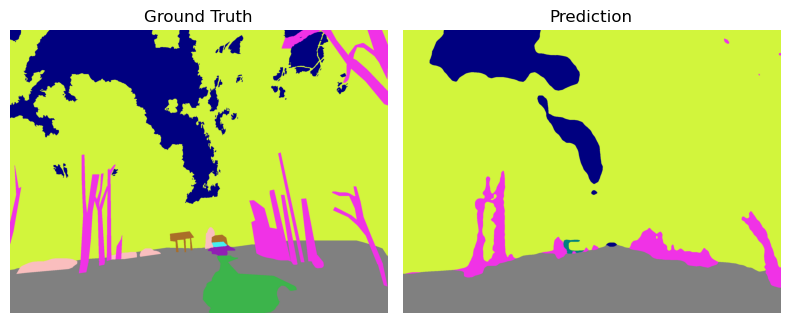

In [25]:
original_image = "img/og_img.png"
truth_label = "img/truth.png"
truth_mask = "img/truth_mask.png"
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic")
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic")
metric = evaluate.load("mean_iou")

inference_single(model,original_image, truth_mask, truth_label, processor, metric)

# Inference on test set
This cell runs `inference_multiple` on the test set.

In [ ]:
train_dataset, val_dataset, test_dataset = get_dataset(
	df_train,
	TRAIN_IMG_PATH,
	TRAIN_MASK_PATH,
	df_val,
	VAL_IMG_PATH,
	VAL_MASK_PATH,
	df_test,
	TEST_IMG_PATH,
	TEST_MASK_PATH
)

# for devices which supports cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic")
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic")
metric = evaluate.load("mean_iou")

inference_multiple(model, test_dataloader, processor, device, metric)

Model for 'mask2former_v2' loaded successfully from /Users/camillechan/WildScenes/mask2former_v2.pth


100%|██████████| 34/34 [33:26<00:00, 59.02s/it]


Selected IoU values: [0.64828259648223, 0.0, 0.0, 0.0, 0.0, 0.4654865176092725, 0.7724875247593833, 3.6128012968646316e-05, 0.0, 0.6783632180426746, 0.1523921410473343, 0.002666326476669971, 0.3799861435015569, 0.5802244598843819, 0.5483877310039128]
Mean IoU: 0.28188751912135895


# Reference
Adapted from:
[1] Vision Transformers: Semantic Segmentation Transfer Learning, available at: https://colab.research.google.com/github/johko/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/transfer-learning-segmentation.ipynb.

[2] Fine Tuning Mask2Former, DebuggerCafe, available at: https://debuggercafe.com/fine-tuning-mask2former/.
